- 首先是对原始数据进行处理：

In [2]:
import pandas

train_df = pandas.read_csv('./other/severstal-steel-defect-detection/train.csv')
train_df['hasMask'] = ~train_df['EncodedPixels'].isnull()
train_df.head()

FileNotFoundError: [Errno 2] File ./other/severstal-steel-defect-detection/train.csv does not exist: './other/severstal-steel-defect-detection/train.csv'

- 可以看到，每张图片都是分成四组用于表示缺陷。具体坐标的表示方法是用一组组起点+长度表示，这里就不展开讲了。

In [8]:
#统计缺陷数量
import numpy as np

mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True) 
print(len(mask_count_df))
mask_count_df.head()

6666


,ImageId,ClassId,hasMask
6253,ef24da2ba.jpg,6,3.0
5740,db4867ee8.jpg,6,3.0
3435,84865746c.jpg,7,2.0
2203,5665ada1b.jpg,7,2.0
6149,eb44ad79d.jpg,7,2.0


In [9]:
#对用于提交的测试集进行处理，并建立生成器
from keras.preprocessing.image import ImageDataGenerator
import cv2

sub_df = pandas.read_csv('./other/severstal-steel-defect-detection/sample_submission.csv')
#sub_df.head()
test_imgs = pandas.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

#生成器设置
BATCH_SIZE = 64

test_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory=r'./other/severstal-steel-defect-detection/test_images',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False #不打乱顺序
    )

Found 5491 validated image filenames.


/Users/wangxun/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 15 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  .format(n_invalid, x_col)


- 下面是绘制坐标和区域相关的函数

In [10]:
#绘制区域相关的函数

def mask2rle(img): 
    pixels= img.T.flatten() 
    pixels = np.concatenate([[0], pixels, [0]]) 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 
    runs[1::2] -= runs[::2] 
    return ' '.join(str(x) for x in runs) 

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    #shape = input_shape[:2] #(256,1600)
    
    mask= np.zeros( width*height ).astype(np.uint8) 
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    
    starts -= 1 #因为起始值是1，所以先要把坐标减一下
    ends = starts + lengths
    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1 
        
    return mask.reshape(height, width).T


def build_masks(rles, classid, input_shape): 
    depth = 4
    #print(depth)
    height, width = input_shape
    #print(input_shape)
    masks = np.zeros((height, width, depth))
    for i, rle in enumerate(rles):
        if type(rle) is str: #因为如果没有rle数据的话，该单元格的数据是nan，即浮点型
            masks[:, :, classid[i]-1] = rle2mask(rle, input_shape) 
    
    return masks

def build_rles(masks): 
    width, height, depth = masks.shape    
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]    
    return rles


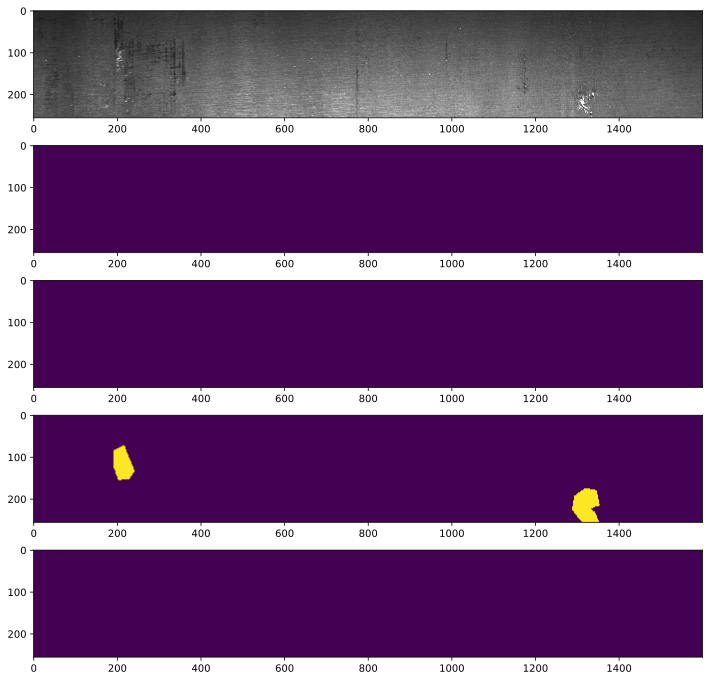

In [11]:
#查看缺陷区域范围
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt


t_img_name ='dc6028399.jpg'
sample_image_df = train_df[train_df['ImageId'] == t_img_name]
sample_path = "./other/severstal-steel-defect-detection/train_images/{}".format(t_img_name)
sample_img = cv2.imread(sample_path,-1)
#sample_img = cv2.imdecode(np.fromfile(sample_path, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
sample_classid=list(sample_image_df['ClassId'])
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, sample_classid, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
#print(axs)
axs[0].imshow(sample_img)
axs[0].axis('on')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('on')

In [12]:
#主要设置__generate_X，__generate_y两个函数，或者直接在getitem里直接设置好

import keras
from keras.models import Sequential

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='./other/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1, #这个注意对应
                 n_classes=4, random_state=1444, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end() #这行不要忘了

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] 

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch) #获取特征值X
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch) #获取返回值y
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self): 
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True: #打乱数据，每次batch结束后重新随机另个index
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch): 
        X = np.empty((self.batch_size, *self.dim, self.n_channels)) 
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            #print(img_path)
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img
        return X
    
    def __generate_y(self, list_IDs_batch): 
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID] 
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            classid = image_df['ClassId'].values
            rles = image_df['EncodedPixels'].values #这里返回的是含有各个类别缺陷标记的数组（4个）
            masks = build_masks(rles, classid, input_shape=self.dim)

            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            #print(img)
            img = img.astype(np.float32) / 255.
            img = np.expand_dims(img, axis=-1)
        except:
            print(img_path)
        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img

In [13]:
#划分训练集和验证集
#train_df: 图片id和对应的缺陷类别，及缺陷的坐标（图片id有重复）
#mask_count_df: 统计了每张图的缺欠总数（包含无缺陷的图片），并且标注了每张图缺陷类别的数量
#non_missing_train_idx: 所有的带缺陷图片合集，并且标注了缺陷种类的数量

from sklearn.model_selection import train_test_split

BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, #包含无缺陷的图片的每张图的缺欠总数，并且标注了每张图缺陷类别的数量
    random_state=1444, 
    test_size=0.15 
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [15]:
#使用项目规定的评定计算方法，在图像识别领域经常用于识别图像间的相似度（重叠度）

from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1): 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [16]:
from keras.models import Model, load_model
from keras.layers import Input
from keras import backend as K
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

inputs = Input((256, 1600, 1)) #原图尺寸，黑白单通道，也可以3通道，注意对应改参数

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5) 

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5) 
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

#残差连接
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55) 
u6 = concatenate([u6, c5]) 
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])#使用之前写的评分函数
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [40]:
from keras.callbacks import Callback, ModelCheckpoint

checkpoint = ModelCheckpoint(
    '/notebooks/severstal-steel-defect-detection/model2.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=10
)

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x102ee0560>
Traceback (most recent call last):
  File "/Users/wangxun/opt/anaconda3/lib/python3.7/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt


Epoch 1/10


KeyboardInterrupt: 

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='upper left')
plt.title('Training and validation loss')
plt.show()

NameError: name 'history' is not defined

In [17]:
from keras.models import load_model
import pandas as pd
import numpy as np
from keras import backend as K

In [18]:
# parameter for loss function
smooth = 1.
 
#  metric function and loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
 
# load model 
model = load_model('modelVGG16+resnet50.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [19]:
def __load_grayscale(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #print(img)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
    except:
        print(img_path)
    return img

In [20]:
X = np.empty((1, 256, 1600, 1)) 

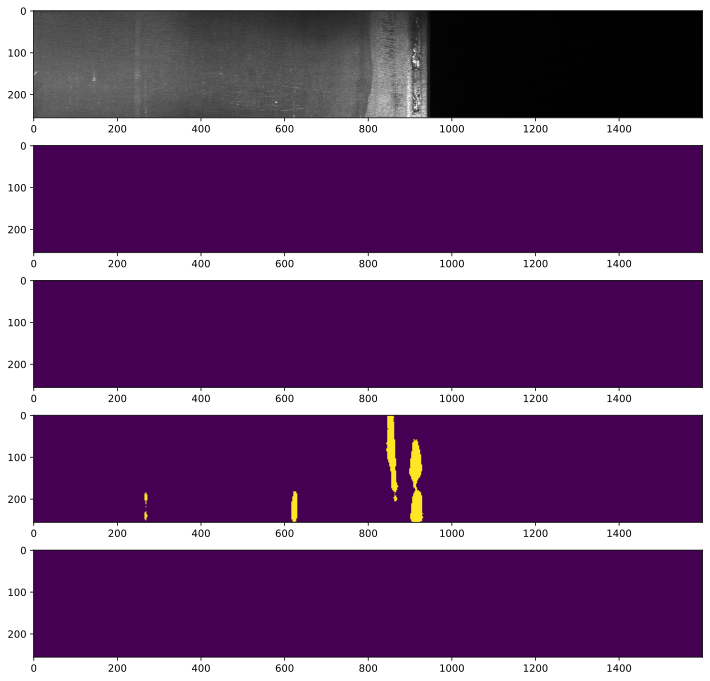

In [21]:
filename = '0014fce06.jpg'
img_path = "./other/severstal-steel-defect-detection/train_images/{}".format(filename)
img = __load_grayscale(img_path)
for i  in range(256):
    X[0,i] = img[i]
a = model.predict(X)
a = a.round().astype(int)
#查看缺陷区域范围
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

sample_img = cv2.imread("./other/severstal-steel-defect-detection/train_images/{}".format(filename),-1)

fig, axs = plt.subplots(5, figsize=(12, 12))
#print(axs)
axs[0].imshow(sample_img)
axs[0].axis('on')

for i in range(4):
    axs[i+1].imshow(a[0, :, :, i])
    axs[i+1].axis('on')

In [111]:
train_df

,ImageId,ClassId,EncodedPixels,hasMask
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,True
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,True
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,True
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,True
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,True
...,...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...,True
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...,True
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...,True
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...,True
